In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm

2024-12-02 19:19:52.396504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def f(X, y, w, lambd):
  n, d = X.shape
  d2 = d * d

  W = np.reshape(w[:d2], (d, d))
  v = w[d2 : d2 + d]
  b = w[-1]

  sum_f = 0
  for j in range(n):
    q = y[j] * (np.inner(X[j], W @ X[j]) + np.inner(v, X[j]) + b)
    # sum_f += np.log(1 + np.exp(-q))
    sum_f += np.maximum(0, -q) + np.log(1 + np.exp(-np.abs(q)))
  return sum_f / n + lambd / 2 * np.linalg.norm(w)**2

def grad_f(X, y, w, lambd):
  n, d = X.shape
  d2 = d * d

  W = np.reshape(w[:d2], (d, d))
  v = w[d2 : d2 + d]
  b = w[-1]

  sum_grad = np.zeros_like(w)
  for j in range(n):
    grad_W = y[j] * np.outer(X[j], X[j])
    grad_v = y[j] * X[j]
    grad_b = y[j]

    grad_q = np.zeros(d2 + d + 1)
    grad_q[:d2] = np.reshape(grad_W, (d2,))
    grad_q[d2 : d2 + d] = grad_v
    grad_q[-1] = grad_b

    q = y[j] * (np.inner(X[j], W @ X[j]) + np.inner(v, X[j]) + b)
    sum_grad += grad_q / (1 + np.exp(q))
  return -sum_grad / n + lambd * w

In [3]:
def plot_convergence(loss, norm_grad_loss):
  fig, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(loss)
  ax1.set_xlabel('Iteration #')
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')

  ax2.plot(norm_grad_loss)
  ax2.set_xlabel('Iteration #')
  ax2.set_ylabel('||grad Loss||')
  ax2.set_yscale('log')

  plt.tight_layout()
  plt.show()

In [4]:
# Load and preprocess the MNIST data
def load_mnist(npcas=None):
  (imgs_train, labels_train), (imgs_test, labels_test) = mnist.load_data()
  imgs_train = imgs_train.reshape((60000, 784))
  imgs_test = imgs_test.reshape((10000, 784))

  imgs_train_1 = imgs_train[labels_train == 1, :]
  imgs_train_7 = imgs_train[labels_train == 7, :]
  imgs_test_1 = imgs_test[labels_test == 1, :]
  imgs_test_7 = imgs_test[labels_test == 7, :]

  imgs_train = np.concatenate((imgs_train_1, imgs_train_7), axis=0)
  imgs_test = np.concatenate((imgs_test_1, imgs_test_7), axis=0)

  labels_train = np.ones(len(imgs_train))
  labels_train[len(imgs_train_1):] = -1
  labels_test = np.ones(len(imgs_test))
  labels_test[len(imgs_test_1):] = -1

  if npcas:
    U, S, Vtrans = np.linalg.svd(imgs_train, full_matrices=False)
    V = np.transpose(Vtrans)
    imgs_train = imgs_train @ V[:, :npcas]
    imgs_test = imgs_test @ V[:, :npcas]

  return imgs_train, imgs_test, labels_train, labels_test

In [5]:
X_train, X_test, lbl_train, lbl_test = load_mnist(npcas=20)

In [6]:
def myloss(w):
  return f(X_train, lbl_train, w, 1e-4)

def mygrad(w):
  return grad_f(X_train, lbl_train, w, 1e-4)

### 1. (a) Deterministic & Stochastic Nesterov

In [7]:
# Nesterov's accelerated gradient descent w/ constant step size alpha
def nesterov(loss, grad, x, alpha):
  v = np.zeros_like(x)
  losses = []

  for k in tqdm(range(100)):
    mu = 1 - 3 / (5 + k)
    v = mu * v - alpha * grad(x + mu * v)
    x = x + v

    losses.append(loss(x))
  return x, losses

In [8]:
d = 20
w = np.ones(d * d + d + 1)
_, losses = nesterov(myloss, mygrad, w, 1e-4)
print(losses)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_30339/2889066252.py:36: RuntimeWarning: overflow encountered in exp
  sum_grad += grad_q / (1 + np.exp(q))
100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

[50499803.35000535, 2395756.3444503704, 1468919.1423153502, 1595185.2906159877, 1773148.5747974806, 1873663.9837701144, 1897927.3785057175, 1868232.587749139, 1804911.479811087, 1722791.91507027, 1638122.4547244585, 1557416.0210201067, 1482424.5477968217, 1410889.8715574336, 1344604.171995877, 1283644.4357827513, 1227827.9810102466, 1176982.8462349002, 1128865.9940070724, 1080963.1698790602, 1035010.7232292048, 992388.8939172262, 952090.2196077956, 912745.622437473, 872240.9036700409, 833144.3921539312, 797821.7147493442, 764662.4227070541, 733514.9168019558, 704971.4733951753, 677882.5958389329, 651719.7092630771, 626166.4627114085, 602246.6489511335, 578458.2474198843, 554957.1728664692, 532868.7343440072, 511488.9809774495, 490008.6326695159, 468502.1959391945, 448084.2151814297, 430008.5306832787, 413204.6149402698, 397288.92704579467, 382185.743881373, 368041.12548825756, 354897.64944332716, 343183.66359077516, 332758.44084561046, 322514.31895392557, 313272.14510189474, 304420.560

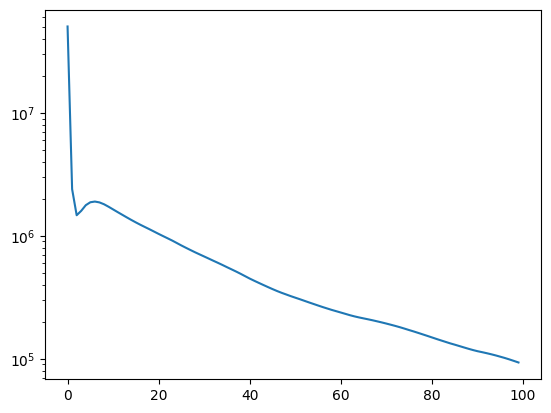

In [9]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [10]:
def stochastic_nesterov():
  return

### 1. (b) Deterministic & Stochastic Adam

In [11]:
# Adam as described in its original paper (https://arxiv.org/pdf/1412.6980)
def adam(loss, grad, theta, alpha=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
  # TODO these should be vectors
  m = 0
  v = 0

  # TODO return lists
  for t in range(10):
    g = grad(theta)
    m = beta_1 * m + (1 - beta_1) * g
    v = beta_2 * v + (1 - beta_2) * g**2
    m_hat = m / (1 - beta_1**t)
    v_hat = v / (1 - beta_2**t)
    theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
  return theta

In [12]:
# adam(myloss, mygrad, TODO)

In [13]:
def stochastic_adam():
  return

### 4. Quadratic Program

In [14]:
def plot_feasible(obj, constrs, min_global, min_constrs):
  s = np.linspace(-2, 5, 1000)
  X, Y = np.meshgrid(s, s)

  plt.contour(X, Y, obj(X, Y), colors='k')
  plt.contour(X, Y, constrs(X, Y))
  plt.scatter(min_global[0], min_global[1], c='r', marker='*')
  plt.scatter(min_constrs[0], min_constrs[1], c='b', marker='*', zorder=2)

  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.show()

In [15]:
def objective(x, y):
  return (x - 1)**2 + (y - 2.5)**2

def constraints(x, y):
  return (x - 2*y + 2 >= 0) & (-x - 2*y + 6 >= 0) & (-x + 2*y + 2 >= 0) & (x >= 0) & (y >= 0)

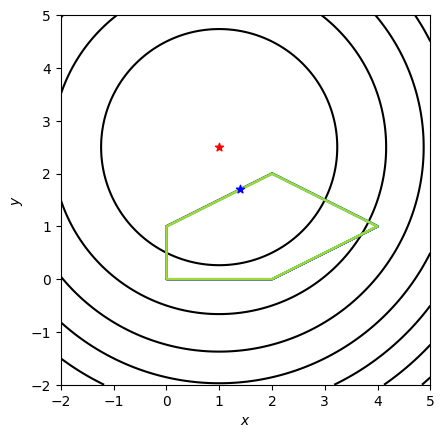

In [16]:
plot_feasible(objective, constraints, [1, 5 / 2], [14 / 10, 17 / 10])